In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, pipeline, preprocessing, linear_model

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_pickle('../data/df_all.pkl')
df.head()

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_two_or_more_races.1,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
0,66 West 38th Street Manhattan NY,2,42,12,22,1,3795,None,https://www.trulia.com/p/ny/manhattan/66-w-38t...,10018,...,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.039550,0.165118,2879,6723
1,435 West 45th Street Manhattan NY,2,42,11,22,1,1950,500,https://www.trulia.com/p/ny/manhattan/435-w-45...,10036,...,0.642167,0.074845,0.004579,0.192712,0.000000,0.065571,0.020125,0.177435,1783,6131
2,56 West 11th Street Manhattan NY,14,42,16,19,0,4550,768,https://www.trulia.com/p/ny/manhattan/56-w-11t...,10011,...,0.794004,0.045889,0.001270,0.101004,0.000079,0.028073,0.029680,0.109456,2131,4002
3,298 Mulberry Street Manhattan NY,2,40,13,17,0,5350,None,https://www.trulia.com/p/ny/manhattan/298-mulb...,10012,...,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.038882,0.058730,2328,2972
4,71 West 107th Street Manhattan NY,14,27,6,15,0,2475,None,https://www.trulia.com/p/ny/manhattan/71-w-107...,10025,...,0.659955,0.121467,0.008341,0.091821,0.000232,0.076238,0.041946,0.227076,418,2027


In [3]:
# check for nulls
df.columns[df.isna().any()].tolist()

['sqft',
 'evac',
 'pct_high_income',
 'demo_total_population',
 'demo_male',
 'demo_female',
 'demo_under_5_years',
 'demo_5_to_9_years',
 'demo_10_to_14_years',
 'demo_15_to_19_years',
 'demo_20_to_24_years',
 'demo_25_to_34_years',
 'demo_35_to_44_years',
 'demo_45_to_54_years',
 'demo_55_to_59_years',
 'demo_60_to_64_years',
 'demo_65_to_74_years',
 'demo_75_to_84_years',
 'demo_85_years_and_over',
 'demo_median_age_(years)',
 'demo_18_years_and_over',
 'demo_21_years_and_over',
 'demo_62_years_and_over',
 'demo_65_years_and_over',
 'demo_18_years_and_over.1',
 'demo_male.1',
 'demo_female.1',
 'demo_65_years_and_over.1',
 'demo_male.2',
 'demo_female.2',
 'demo_one_race',
 'demo_two_or_more_races',
 'demo_one_race.1',
 'demo_white',
 'demo_black_or_african_american',
 'demo_american_indian_and_alaska_native',
 'demo_asian',
 'demo_native_hawaiian_and_other_pacific_islander',
 'demo_some_other_race',
 'demo_two_or_more_races.1',
 'demo_hispanic_or_latino_(of_any_race)',
 'demo_pct_

In [4]:
# check which zip codes have NULL values
df[pd.isnull(df.demo_total_population)]['zip_code'].unique()

array([11249])

In [5]:
# how many records contain this zip code
df[df['zip_code']==11249]['zip_code'].count()

70

In [6]:
# drop rows containing this zip code
df = df[df.zip_code != 11249].copy()

In [7]:
# check for nulls
df.evac.unique()

array([None, '2', '5', '4', '6', '1', '3', 'c'], dtype=object)

In [8]:
# fix feature name to feed to patsy
df.rename(columns={'flooring:_hardwood': 'flooring_hardwood'}, inplace=True)
df.rename(columns={'off-street_parking': 'off_street_parking'}, inplace=True)

In [9]:
# create a list of all columns not related to demo data
non_demo_cols = [col for col in df.columns if 'demo' not in col]
df[non_demo_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6272 entries, 0 to 6341
Data columns (total 50 columns):
address                    6272 non-null object
days_on_trulia             6272 non-null int64
elementary_school_count    6272 non-null int64
high_school_count          6272 non-null int64
middle_school_count        6272 non-null int64
pets_allowed               6272 non-null int64
price                      6272 non-null int64
sqft                       2293 non-null object
url                        6272 non-null object
zip_code                   6272 non-null int64
school_count               6272 non-null int64
evac                       1559 non-null object
guarantor                  6272 non-null int64
storage                    6272 non-null int64
garage                     6272 non-null int64
deck                       6272 non-null int64
elevator                   6272 non-null int64
dishwasher                 6272 non-null int64
pets                       6272 non-null in

In [10]:
# create a list with non-numerical columns 
non_num = ['address','url','evac','zip_code']
non_demo_cols = list(set(non_demo_cols).difference(set(non_num)))

# create a list with demo columns
demo_cols = [col for col in df.columns if 'demo' in col]
print('Non-demo columns:', len(non_demo_cols))
print('Demo columns:    ', len(demo_cols))

Non-demo columns: 46
Demo columns:     75


In [11]:
# create of non-demo numerical and booleam column lists
non_demo_num = ['sqft','median_income','middle_school_count','elementary_school_count','school_count',
               'high_school_count', 'n_of_establishments', 'rest_num', 'days_on_trulia', 'price', 'pct_high_income']

# create a list of binary columns
non_demo_bool = list(set(non_demo_cols).difference(set(non_demo_num)))

# remove dep var from non_demo_num list
non_demo_num.remove('price')

# remove sqft for now since it countains NULL values
non_demo_num.remove('sqft')

In [12]:
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [13]:
non_demo_bool

['flooring_hardwood',
 'leed_registered',
 'pool',
 'balcony',
 'valet_parking',
 'dryer',
 'live_in_super',
 'garden',
 'pied_a_terre',
 'courtyard',
 'dishwasher',
 'storage',
 'pets',
 'sublets',
 'furnished',
 'concierge',
 'garage',
 'fios_available',
 'guarantor',
 'deck',
 'washing_machine',
 'air_conditioning',
 'off_street_parking',
 'cable_tv_ready',
 'fitness_center',
 'board_approval_required',
 'childrens_playroom',
 'pets_allowed',
 'microwave_oven',
 'fireplace',
 'terrace',
 'parents',
 'co_purchase',
 'elevator',
 'recreation_facilities']

In [14]:
demo_cols

['demo_total_population',
 'demo_male',
 'demo_female',
 'demo_under_5_years',
 'demo_5_to_9_years',
 'demo_10_to_14_years',
 'demo_15_to_19_years',
 'demo_20_to_24_years',
 'demo_25_to_34_years',
 'demo_35_to_44_years',
 'demo_45_to_54_years',
 'demo_55_to_59_years',
 'demo_60_to_64_years',
 'demo_65_to_74_years',
 'demo_75_to_84_years',
 'demo_85_years_and_over',
 'demo_median_age_(years)',
 'demo_18_years_and_over',
 'demo_21_years_and_over',
 'demo_62_years_and_over',
 'demo_65_years_and_over',
 'demo_18_years_and_over.1',
 'demo_male.1',
 'demo_female.1',
 'demo_65_years_and_over.1',
 'demo_male.2',
 'demo_female.2',
 'demo_one_race',
 'demo_two_or_more_races',
 'demo_one_race.1',
 'demo_white',
 'demo_black_or_african_american',
 'demo_american_indian_and_alaska_native',
 'demo_asian',
 'demo_native_hawaiian_and_other_pacific_islander',
 'demo_some_other_race',
 'demo_two_or_more_races.1',
 'demo_hispanic_or_latino_(of_any_race)',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_

In [15]:
# check dep var stats
df.price.describe()

count     6272.000000
mean      2720.768495
std       1542.082094
min        390.000000
25%       1799.000000
50%       2425.000000
75%       3286.500000
max      71850.000000
Name: price, dtype: float64

In [16]:
# see outliers on the high end
df[df.price>10000]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_two_or_more_races.1,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
1059,160 Central Park South Manhattan NY,46,34,9,20,0,12900,750,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.032907,0.152386,1782,4832
1221,795 5th Avenue New York NY,62,34,9,20,1,20000,975,https://www.trulia.com/p/ny/new-york/795-5th-a...,10065,...,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.011733,0.060631,1573,1492
1355,15 Central Park West Manhattan NY,77,30,10,21,1,11500,"1,342",https://www.trulia.com/p/ny/manhattan/15-centr...,10023,...,0.820900,0.034159,0.001841,0.103968,0.000348,0.017792,0.020993,0.105427,1225,2384
1368,128 East 70th Street Manhattan NY,79,32,9,20,0,10500,None,https://www.trulia.com/p/ny/manhattan/128-e-70...,10021,...,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.034931,0.074148,884,3009
1424,210 East 65th Street New York NY,90,33,8,20,1,11700,643,https://www.trulia.com/p/ny/new-york/210-e-65t...,10065,...,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.011733,0.060631,1112,1492
1537,160 Central Park South Manhattan NY,213,34,9,20,0,11300,791,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.032907,0.152386,1782,4832
1814,166 Perry Street Manhattan NY,30,45,17,19,1,10500,"1,126",https://www.trulia.com/p/ny/manhattan/166-perr...,10014,...,0.889207,0.013253,0.004005,0.056255,0.000000,0.018434,0.018847,0.068332,1026,2454
1927,7 East 20th Street Manhattan NY,50,43,14,21,1,10900,"2,400",https://www.trulia.com/p/ny/manhattan/7-e-20th...,10003,...,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.028432,0.078743,2153,4318
2026,1 Central Park South Manhattan NY,101,35,10,20,1,12895,None,https://www.trulia.com/p/ny/manhattan/1-centra...,10019,...,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.032907,0.152386,1759,4832
2060,42 West 58th Street Manhattan NY,172,36,10,21,0,71850,"1,500",https://www.trulia.com/p/ny/manhattan/42-w-58t...,10019,...,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.032907,0.152386,1868,4832


In [17]:
# see outliers on the ;ow end
df[df.price<500]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_two_or_more_races.1,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
3496,117 Avenue T Brooklyn NY,19,56,6,35,0,390,None,https://www.trulia.com/rental/4045692209-117-A...,11223,...,0.633375,0.041402,0.004979,0.229437,0.002069,0.069296,0.019441,0.134705,190,2137


In [18]:
df[non_demo_num].describe()

,median_income,middle_school_count,elementary_school_count,school_count,high_school_count,n_of_establishments,rest_num,days_on_trulia,pct_high_income
count,6272.000000,6272.000000,6272.00000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,77900.886001,19.960938,35.81824,64.468750,8.689573,2308.647800,843.970823,27.099171,15.028189
std,32224.488307,6.785896,11.23259,20.222719,4.436418,1656.241665,1118.292186,40.366769,11.589212
min,21553.000000,6.000000,15.00000,29.000000,2.000000,74.000000,1.000000,-1.000000,0.400000
25%,51864.000000,15.000000,26.00000,47.000000,5.000000,1079.000000,253.000000,6.000000,4.200000
50%,75362.000000,19.000000,35.00000,64.000000,8.000000,1967.000000,452.000000,15.000000,10.400000
75%,108178.000000,23.000000,42.00000,77.000000,12.000000,3015.000000,1180.250000,34.000000,24.900000
max,250001.000000,41.000000,64.00000,121.000000,28.000000,7373.000000,11931.000000,889.000000,59.900000


In [19]:
# check negative values in 'days on Trulia' 
df.loc[df.days_on_trulia < 0]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_two_or_more_races.1,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
2072,323 East 75th Street Manhattan NY,-1,30,7,19,0,4750,None,https://www.trulia.com/p/ny/manhattan/323-e-75...,10021,...,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.034931,0.074148,739,3009
2073,185 Bleecker Street Manhattan NY,-1,42,14,19,0,3200,None,https://www.trulia.com/p/ny/manhattan/185-blee...,10012,...,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.038882,0.058730,1655,2972
2075,1657 Madison Avenue Manhattan NY,-1,27,6,16,0,1800,None,https://www.trulia.com/p/ny/manhattan/1657-mad...,10029,...,0.346891,0.289418,0.002330,0.087041,0.001574,0.246528,0.026218,0.474065,480,1065
2076,75 East 3rd Street Manhattan NY,-1,40,13,17,0,2750,None,https://www.trulia.com/p/ny/manhattan/75-e-3rd...,10003,...,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.028432,0.078743,1945,4318
2077,330 East 38th Street Manhattan NY,-1,40,14,21,1,3800,763,https://www.trulia.com/p/ny/manhattan/330-e-38...,10016,...,0.726072,0.030469,0.001348,0.195702,0.000000,0.008148,0.038260,0.086056,1383,6042
2078,346 West 36th Street Manhattan NY,-1,42,12,22,1,2000,600,https://www.trulia.com/p/ny/manhattan/346-w-36...,10018,...,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.039550,0.165118,2068,6723
2079,92 Morningside Avenue Manhattan NY,-1,25,4,13,0,3256,None,https://www.trulia.com/p/ny/manhattan/92-morni...,10027,...,0.299969,0.414005,0.004757,0.096709,0.000078,0.148097,0.036385,0.240814,449,1049
2081,328 East 15th Street Manhattan NY,-1,42,16,20,1,2400,700,https://www.trulia.com/p/ny/manhattan/328-e-15...,10003,...,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.028432,0.078743,1516,4318
2082,377 Rector Place Manhattan NY,-1,39,14,19,1,3050,654,https://www.trulia.com/p/ny/manhattan/377-rect...,10280,...,0.770340,0.015846,0.000000,0.165566,0.000000,0.019299,0.028949,0.112443,908,163


In [20]:
# after checking on site, it looks like -1 value was meant to be 1
# change 1 day and 0 days to 1 to be able to put a log on it
df.loc[df.days_on_trulia < 1, 'days_on_trulia'] = 1

# Visualization

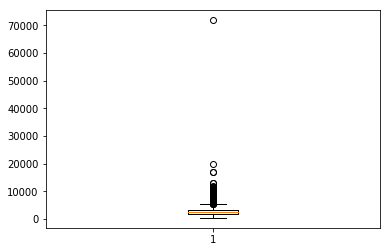

In [21]:
# dep variable distribution
plt.boxplot(df.price);

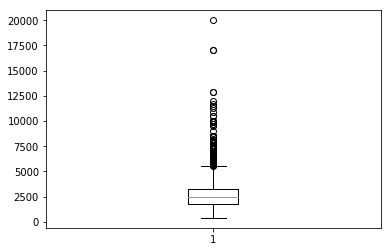

In [22]:
# remove the outlier and plot
df = df[df.price<70000].copy()
# dep variable distribution
plt.boxplot(df.price);

Text(0.5,1,'Monthly 1br Rent Price')

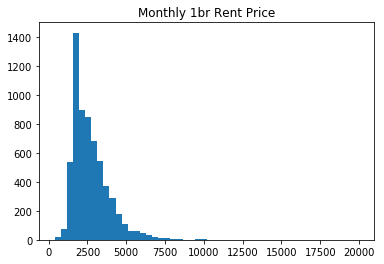

In [23]:
plt.hist(df.price, bins = 50);
plt.title('Monthly 1br Rent Price')

Text(0,0.5,'log scale')

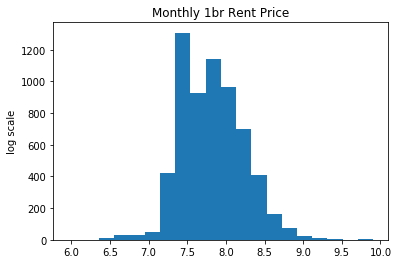

In [24]:
# the data is right-skewed: create a dep var column on a log scale & plot
df['price_log'] = np.log(df.price)
plt.hist(df.price_log, bins = 20);
plt.title('Monthly 1br Rent Price')
plt.ylabel('log scale')

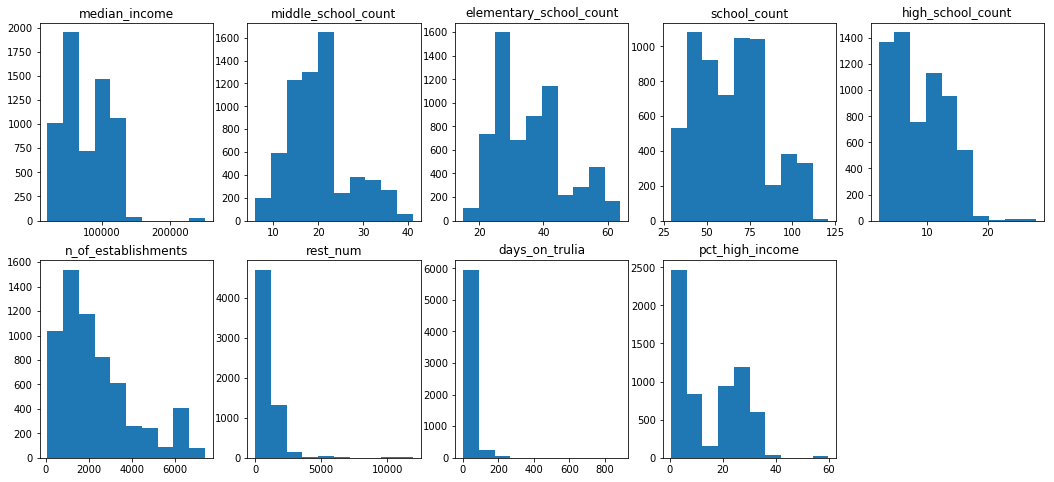

In [25]:
plt.figure(figsize=(18, 8))

for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.hist(df[var])
    plt.title(var);

In [26]:
# change highly-skewed variables into log vars
df['median_income'] = np.log(df.median_income)
df['pct_high_income'] = np.log(df.pct_high_income)
df['rest_num'] = np.log(df.rest_num)
df['days_on_trulia'] = np.log(df.days_on_trulia)

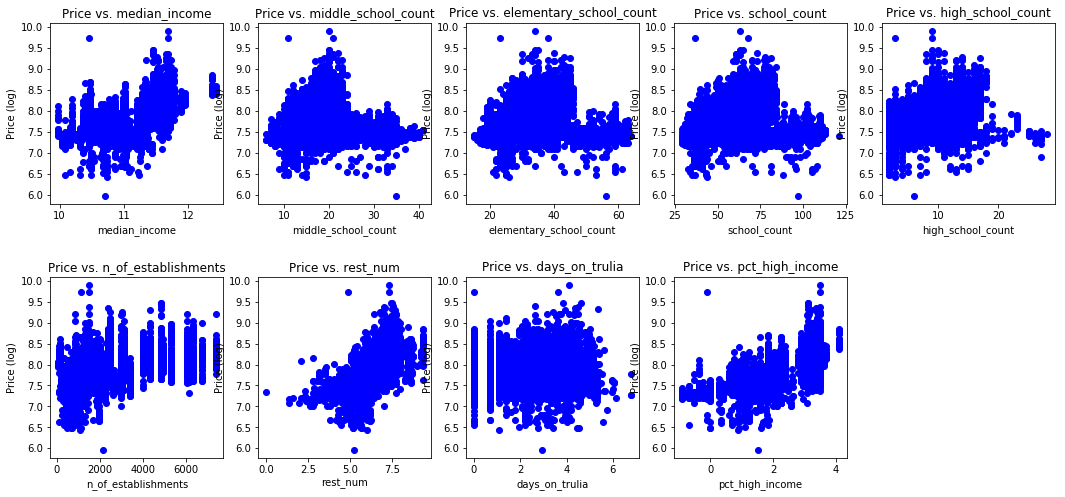

In [27]:
# create scatter plolts with dep var (log) against non_demo_num vars
plt.figure(figsize=(18, 8))
y = df['price_log']
for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.plot(df[var], y,'bo')
    plt.subplots_adjust(hspace = 0.4)
    plt.xlabel(var)
    plt.ylabel('Price (log)')
    plt.title(f'Price vs. {var}');

### Observations:
- Number of restaurants (log rest_num) has positive correlation with apt price <br>
- % of HI households (pct_hight_income) also has a positive correlation with apt price <br>
- The number of schools in the neighborhood doesn't seem to be correlated to the price, which is not suprprising for one bedroom apartements

In [37]:
# school count variables are expected to be multicollinear, let's test that
school_vars = ['middle_school_count',
 'elementary_school_count',
 'school_count',
 'high_school_count']

df[school_vars].corr()

,middle_school_count,elementary_school_count,school_count,high_school_count
middle_school_count,1.000000,0.871883,0.911028,0.415667
elementary_school_count,0.871883,1.000000,0.978132,0.593135
school_count,0.911028,0.978132,1.000000,0.688310
high_school_count,0.415667,0.593135,0.688310,1.000000


In [28]:
len(non_demo_bool)

35

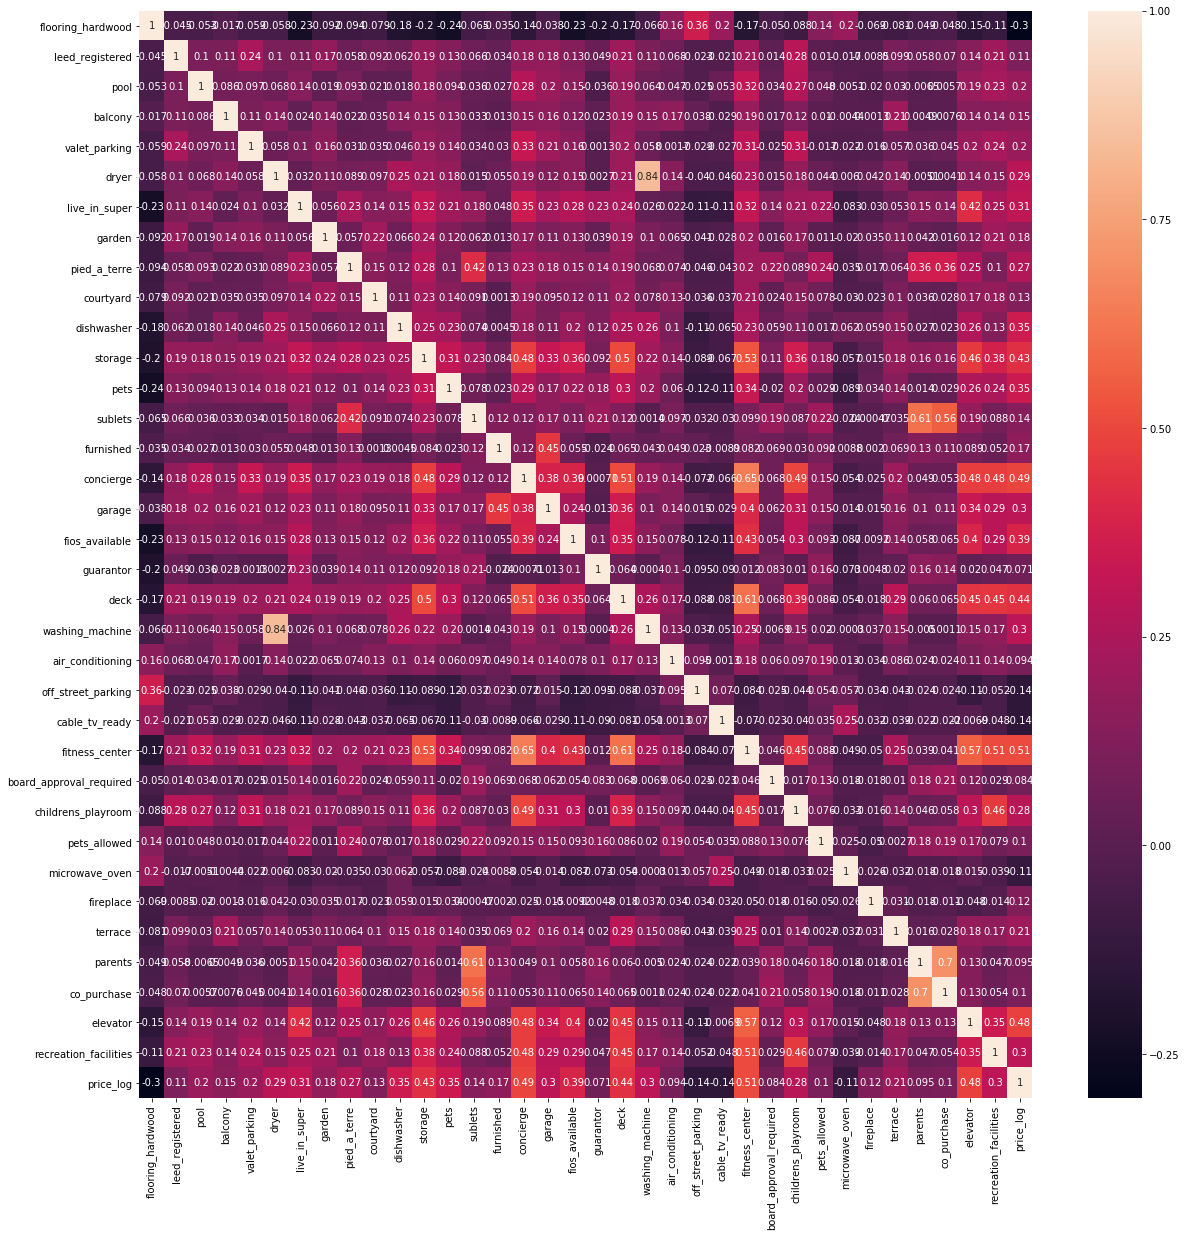

In [29]:
non_demo_bool.append('price_log')

f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df[non_demo_bool].corr(), annot=True)
plt.show()

### Observations:
- from all features 'fitness center' has the highest correlation with the 1br apt rent price
- concierge, garage, deck and storage also have moderate correlation with rent price
- washing machine should be merged with dryer into one since they are highly correlated features

In [30]:
# merge washing machine and dryer
df['wash_dry'] = df.loc[(df['washing_machine'] == 1) |  (df['dryer'] == 1), 'wash_dry'] = 1
# drop the other two columns
df.drop(labels = ['washing_machine', 'dryer'], axis=1, inplace=True)
# update non_demo_bool list
non_demo_bool.remove('washing_machine')
non_demo_bool.remove('dryer')
non_demo_bool.append('wash_dry')
# remove price_log from non_demo_bool
non_demo_bool.remove('price_log')

# Modeling

### Linear Regression with Dep Var (non log scale)

In [32]:
# split data into test and train 
x = df.drop(labels=['price', 'price_log'], axis=1)
y = df['price']

X_train , X_test, y_train, y_test = model_selection.train_test_split(x,y, test_size = 0.2)

In [33]:
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price'] = y_train

# create a string for patsy input
non_demo_num_str = 'price' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price ~ median_income + middle_school_count + elementary_school_count + school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [34]:
# create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y, X)
# fit model to training set
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     589.6
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        10:45:27   Log-Likelihood:                -41227.
No. Observations:                5016   AIC:                         8.247e+04
Df Residuals:                    5007   BIC:                         8.253e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -780.7200    854.263     -0.914      0.361   -2455.449     894.009
median_income               8.6160     82.069      0.105      0.916    -152.276     169.508
middle_school_count       -20.9526      3.548     -5.906      0.000     -27.908     -13.998
elementary_school_count   -14.9719      3.603     -4.155      0.000     -22.035      -7.909
school_count                8.4242      1.120      7.524      0.000       6.229      10.619
high_school_count          44.3488      3.622     12.244      0.000      37.248      51.450
n_of_establishments         0.0089      0.011      0.794      0.428      -0.013       0.031
rest_num                  380.9714     18.511     20.581      0.000     344.682     417.261
days_on_trulia             59.0114      9.708      6.079      0.000      39.980      78.043
pct_high_income           385.5301     37.523     10.275      0.000     311.969     459.091
==============================================================================
Omnibus:                     4511.634   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           412878.634
Skew:                           3.915   Prob(JB):                         0.00
Kurtosis:                      46.751   Cond. No.                     9.42e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
features = [
 'middle_school_count',
 'elementary_school_count',
 'school_count',
 'high_school_count',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [ ]:
# test the model with the high p-val variables removed
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price'] = y_train

# create a string for patsy input
non_demo_num_str = 'price' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

In [31]:
# split data into test and train 
x = df.drop(labels=['price', 'price_log'], axis=1)
y = df['price_log']

X_train , X_test, y_train, y_test = model_selection.train_test_split(x,y, test_size = 0.2)

In [35]:
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price_log'] = y_train

# create a string for patsy input
non_demo_num_str = 'price_log' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price_log ~ median_income + middle_school_count + elementary_school_count + school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [36]:
# create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y, X)
# fit model to training set
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     992.8
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:10:05   Log-Likelihood:                -262.24
No. Observations:                5016   AIC:                             542.5
Df Residuals:                    5007   BIC:                             601.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.2553      0.245     33.714      0.000       7.775       8.735
median_income              -0.1558      0.024     -6.620      0.000      -0.202      -0.110
middle_school_count        -0.0070      0.001     -7.049      0.000      -0.009      -0.005
elementary_school_count    -0.0055      0.001     -5.335      0.000      -0.007      -0.003
school_count                0.0025      0.000      8.066      0.000       0.002       0.003
high_school_count           0.0150      0.001     14.705      0.000       0.013       0.017
n_of_establishments     -1.509e-06   3.16e-06     -0.477      0.633   -7.71e-06    4.69e-06
rest_num                    0.1294      0.005     24.445      0.000       0.119       0.140
days_on_trulia              0.0160      0.003      5.817      0.000       0.011       0.021
pct_high_income             0.2228      0.011     20.780      0.000       0.202       0.244
==============================================================================
Omnibus:                      685.773   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4340.922
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       7.453   Cond. No.                     7.22e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.75e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
non_demo_bool_str

'price_log ~ elevator + courtyard + deck + board_approval_required + storage + leed_registered + childrens_playroom + valet_parking + cable_tv_ready + pied_a_terre + concierge + air_conditioning + co_purchase + garden + pets + live_in_super + microwave_oven + balcony + terrace + guarantor + pets_allowed + garage + fitness_center + pool + furnished + fireplace + parents + off_street_parking + flooring_hardwood + fios_available + recreation_facilities + dishwasher + sublets + wash_dry'

In [37]:
# use patsy on non_demo_bool features only
df_train = X_train[non_demo_bool].copy()
df_train['price_log'] = y_train

# create a string for patsy input
non_demo_bool_str = 'price_log' + ' ~ ' + ' + '.join(non_demo_bool)

# create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(non_demo_bool_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y, X)
# fit model to training set
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     141.1
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:10:13   Log-Likelihood:                -990.00
No. Observations:                5016   AIC:                             2048.
Df Residuals:                    4982   BIC:                             2270.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.7891      0.004    975.999      0.000       3.782       3.797
elevator                    0.1298      0.012     11.270      0.000       0.107       0.152
courtyard                  -0.0711      0.020     -3.603      0.000      -0.110      -0.032
deck                        0.0584      0.014      4.108      0.000       0.031       0.086
board_approval_required     0.0058      0.031      0.184      0.854      -0.056       0.067
storage                     0.0387      0.012      3.137      0.002       0.015       0.063
leed_registered            -0.1393      0.034     -4.132      0.000      -0.205      -0.073
childrens_playroom         -0.0402      0.022     -1.836      0.066      -0.083       0.003
valet_parking               0.0713      0.028      2.557      0.011       0.017       0.126
cable_tv_ready             -0.1356      0.029     -4.631      0.000      -0.193      -0.078
pied_a_terre                0.1462      0.019      7.521      0.000       0.108       0.184
concierge                   0.1768      0.017     10.225      0.000       0.143       0.211
air_conditioning            0.0179      0.014      1.280      0.201      -0.010       0.045
co_purchase                 0.0731      0.045      1.616      0.106      -0.016       0.162
garden                      0.0822      0.016      5.049      0.000       0.050       0.114
pets                        0.0832      0.010      8.282      0.000       0.064       0.103
live_in_super               0.0222      0.011      2.046      0.041       0.001       0.044
microwave_oven             -0.2235      0.036     -6.208      0.000      -0.294      -0.153
balcony                     0.0236      0.014      1.750      0.080      -0.003       0.050
terrace                     0.0313      0.019      1.663      0.096      -0.006       0.068
guarantor                  -0.0267      0.011     -2.500      0.012      -0.048      -0.006
pets_allowed                0.0087      0.010      0.845      0.398      -0.011       0.029
garage                     -0.0274      0.015     -1.852      0.064      -0.056       0.002
fitness_center              0.1039      0.016      6.365      0.000       0.072       0.136
pool                        0.0964      0.021      4.561      0.000       0.055       0.138
furnished                   0.1986      0.023      8.607      0.000       0.153       0.244
fireplace                   0.2474      0.021     11.653      0.000       0.206       0.289
parents                    -0.0357      0.047     -0.765      0.444      -0.127       0.056
off_street_parking         -0.0488      0.028     -1.749      0.080      -0.103       0.006
flooring_hardwood          -0.1295      0.017     -7.798      0.000      -0.162      -0.097
fios_available              0.0820      0.011  

In [ ]:
# impute sqft - (options: mean/ make linear regression to predict sqft)
# get lat/long data